In [1]:
import numpy as np
import matplotlib.pyplot as pl
import dask.array as da

In [26]:
def radial_profile(data: np.ndarray, centre: tuple):
    """_summary_

    Parameters
    ----------
    data : np.ndarray
        _description_
    centre : tuple
        _description_

    Returns
    -------
    _type_
        _description_
    """
    
    x, y = np.indices((data.shape))
    r = np.sqrt((x - centre[0]) ** 2 + (y - centre[1]) ** 2)
    r = r.astype(int)
    tbin = np.bincount(np.ravel(r), np.ravel(data))
    nr = np.bincount(np.ravel(r))
    radialprofile = tbin / nr
    return radialprofile

In [8]:
#read in data
from ddm.data_handling import readLIF
dData = readLIF('../tests/data/testData3series.lif')

from ddm.data_handling import readTIF
dData3 = readTIF('../tests/data/21-03-31_ddm_water_control_sample.tif')

from ddm.data_handling import readND2
dData2 = readND2('../tests/data/testData10frames.nd2')

The datafile contains the following experiments:
0 : well1_ha_4mg-ml_fg_2mg-ml
1 : well2_ha_2mg-ml_fg_2mg-ml
2 : well4_ha_2mg-ml
Please select the experiment you want to process [0, 1, 2] 
1


In [ ]:
#dummy data for testing
dData = np.random.randint(0, 256, size = (20, 512, 512))

In [51]:
#method 1 - high q for A = 0 - rework to optimise the FFTs???
def findMeanSqFFT(dumData):
    sqFFT = 2*da.abs(da.fft.fft2(dumData))*np.abs(da.fft.fft2(dumData))
    sqFFT = da.fft.fftshift(sqFFT)
    sqFFTmean = da.mean(sqFFT, axis = 0)
    return sqFFTmean/(np.shape(sqFFTmean)[0]*np.shape(sqFFTmean[1]))

In [52]:
def computeAB(sqFFTmean):
    sqFFTrad = radial_profile(sqFFTmean, (np.shape(sqFFTmean)[0]/2, np.shape(sqFFTmean)[1]/2))
    b = np.mean(sqFFTrad[-100:-50]) #change depending on size of array
    a = sqFFTrad - b
    return a, b

In [53]:
meanSQ = findMeanSqFFT(dData2.data)

In [54]:
meanSQ = meanSQ.compute()

In [55]:
A, B = computeAB(meanSQ)

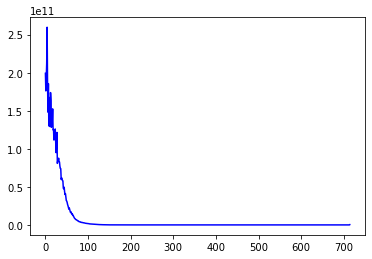

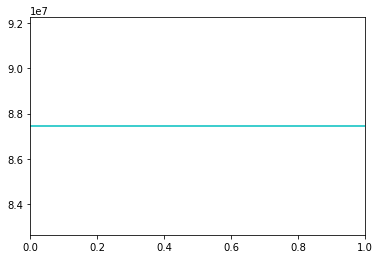

In [56]:
#method 2 - delay time is zero then A = real part of squared stuff
fTFt = np.fft.fftshift(2*np.fft.fft2(dData2)*np.conj(np.fft.fft2(dData2, axes = (0,1))))
aFull = np.real(np.mean(fTFt, axis = 0))
c = radial_profile(aFull, (512, 512))
pl.figure(0)
#pl.plot(c[10:], color = 'r')
pl.plot(A[10:], color = 'b')

SqFFT = 2*np.abs(np.fft.fft2(dData2)**2)
SqFFT = np.fft.fftshift(SqFFT)
SqFFTmean = np.mean(SqFFT, axis = 0)
SqFFTrad = radial_profile(SqFFTmean, (512, 512))

d = SqFFTrad - c

pl.figure(1)
#pl.plot(d[10:], color = 'm')
pl.axhline(B, color = 'c')